# Machine Failure Classification

## Problem statement 
> **Can we use machine learning to help factory owners and maintence staff predict which machine are going to fail?**

### Problem Understanding 
Typically in the process of checking for possible signs of machine failure , a factory owner would hire professional to do regular checks on the machines to prevent it from failing . The process of checks are repetitive and would haunt the manufacturing process of the factory machines.

#### Key things to take note 
Cost of breakdown is not just the opportunity loss (of potential profit from production), but it also includes fixed cost of the machine. Further, delay in production can attract penalties and lost orders. At times, when other machines also depend on the failed machinery, the cost escalates through the roof. The cost of single breakdown can easily exceed thousands of dollars. The worst part is, this loss can hardly ever be recovered which leads to the evaluation metrics.


### Evaulation Metrics
Due to the delay in product ,high opportunity cost and maintenance cost that comes with machine failure, i would focus on the identifying machines that is going to fail which is Recall.

Recall is defined by 
$$
Recall = \frac{True Positive}{True Positive+False Negative}
$$

The second metrics is wrong classification need to be > 0.85 But we dont need to worry about this as this dataset is imbalance and even a DummyClassifier will get above 97% accuracy.
Based on an article on predictive maintenance.A usual benchmark is that the total plant availability (or maximum available time) should be greater than 97%. Further, around 85-95% of maintenance activities should be either planned or scheduled – this leaves reactive maintenance activities to be less than 15%.https://www.upkeep.com/learning/how-to-benchmark-maintenance-performance


Hence, our objective would be to :
- create a model that can supplment a technican to help predict which machines is going to fail and maintain them
- extract insights as to how important different factors affect Machine failure

    

## Question

How is your prediction task defined? And what is the meaning of the output variable?

   1--> machine will fail
   0 --> machines will not fail
    
How do you represent your data as features?

   for numerical features like Machine Quality I used ordinal encoding to encode it as there's inherent hierarchy
    
    
Did you process the features in any way?
    For features like Rotation speed which has a skewed distribution i first applied a log normal transformation then due to the presence of outliers , i used robust scaling to minimise the effect of it.
    I also oversampled the data using a addon module called Imbalance-learn which contains oversampling methods like SMOTE.
    Reason why i use SMOTEENN as due to the massive imbalance undersampling would be a waste of data. Futhermore SMOTEENN is a combination of oversampling and undersampling which helps to reduce noise in the data and achieves better performance based on a research paper written by Cornell .https://arxiv.org/abs/2004.03409.
    
    Other than that , i also created more features that would complement the current features such as Power,Heat dissipation and overstrain .These features are relevant metrics in a real factory settings.The formula for these is placed below.


How did you select which learning algorithms to use?
    Firstly , i do a mass training of algorithm to see which models have a high Cross-validation score right off the bat.Then i select the top 3 algorithm and tune it's hyperparameters to see which model gives the best Recall score and looking at the learning curve to determine if it's overfitting or underfitting


Did you try to tune the hyperparameters of the learning algorithm, and in that case how?
    I used halving-gridsearch to tune my hyperparamters . Halving Gridsearch is a searching strategy that starts evaluating candiates with a small amount of resources and iteratively select the best candidates . Which is a less time consuming strategy. In my hyperparaters , i added ccp_alpha which can help to reduce model overfitting as it is quite common in Tree models.

How do you evaluate the quality of your system?
    I mainly evaluated my algorithms with recall score as in this context we would want to predict as much machines that could have error
    
    
How well does your system compare to a stupid baseline?
    A stupid baseline would always predict the more frequently appeared class in this case would be the 0 , machine will not fail. Doing so will allow the machine to have the highest possible accuracy at 0.962 but will classify all the machine that will fail are working . This strategy is being penalized by the evaluation metrics i have set which is recall and will result in a recall score of 0 .
    
    Using the evaluation metrics that i have defined which is recall , 


    My model has a very low false negative rate , but it sacrifices on it's precision since there's a tradeoff between precision and recall .
    
    
Is it possible to say something about which features the model considersimportant? (Whether this is possible depends on the type of classifieryou are using)
   Somethings unexpected is that based on analysis of feature importance ,Quality of machinery doesnt actually play a big part in predicting if machines are going to fail. 
   The most important feature would be torque and rotation speed . 
   


In [576]:
import numpy as np
import pandas as pd
from sklearn import datasets
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, make_scorer, fbeta_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing  import OrdinalEncoder,OneHotEncoder,RobustScaler,LabelEncoder,PowerTransformer,StandardScaler
from time import time
import warnings
warnings.filterwarnings('ignore')

In [577]:
df = pd.read_csv('factory_data (classification).csv') 


In [578]:
df

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...,...
19995,19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19996,19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0


In [579]:
df.groupby("Machine Status").count()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
Machine Status,,,,,,,,
0,19322,19322,18364,19322,18939,18171,19322,19322
1,678,678,645,678,661,641,678,678


## Immediately i notice there's null values 

In [580]:
df.isnull().sum()

Unique ID                  0
Product ID                 0
Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
dtype: int64

Since there's null values , i would need to check what kind of missing value it is.

1. Missing completely at Random
2. Missing At Random
3. Missing not at Random

The steps to check goes as follow . 
1. make a column that indicate 1 if data is missing and 0 if not 
2. run correlation test to see if there's any trends 

In [581]:
df_check_random = df.copy()

In [582]:
df_check_random['null flag'] = np.where(df_check_random.notna().all(axis=1), 0,1)
df_check_random = df_check_random.drop(['Unique ID','Product ID'],axis=1 )

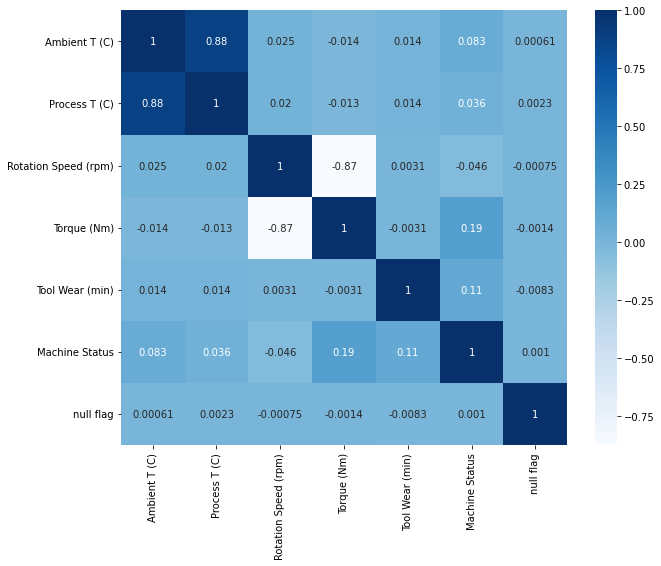

In [583]:
plt.figure(figsize=(10,8))
sns.heatmap(df_check_random.corr(), cmap="Blues", annot=True);

since there's little correlation between teh variable and the null flag , i can conclude that it is Missing completely at Random

### Dropped Unique ID and Product ID as they provide no value due to it's high cardinality and only have the function of identifying the rows

In [584]:
df = df.drop(["Unique ID","Product ID"], axis=1)

## Inputating null values

- checking different inputation methods so to see which have the best result

### Method to find the most effective methods
I am going to use the standard approach which is to select some observation and set their status to missing and inpute them with different methods and compare their prediction accuracy using Root Mean Squared Error and Percentage of Correct Prediction

Since the data is missing completely at random , it is more advisable to use knn inputer and iterative inputer compared to the mean , median because it gives a more robust and accurate value

In [585]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [586]:
#manually add missing data 
df_inpute_method = df.dropna(how='any',axis=0)

In [587]:

actual = df_inpute_method.iloc[:200].copy()
actual['Quality'] = le.fit_transform(actual['Quality'])

In [588]:
#manually add missing data 
df_inpute_method = df.dropna(how='any',axis=0)
actual = df_inpute_method.iloc[:200].copy()
actual['Quality'] = le.fit_transform(actual['Quality'])

#Generate null values
count = 0 
for index, row in df_inpute_method.iterrows():
    df_inpute_method.loc[index,['Process T (C)']] = np.nan
    df_inpute_method.loc[index,['Rotation Speed (rpm)']] = np.nan
    df_inpute_method.loc[index,['Quality']] = np.nan
    count += 1
    if count == 200:
        break

In [589]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

df_inpute_method['Quality'] = le.fit_transform(df_inpute_method['Quality'])
knnimputer = KNNImputer()
knninputer_result = knnimputer.fit_transform(df_inpute_method)
#calculate the RMSE and accuracy 

knninputer_dict = {
     "Quality":accuracy_score(actual['Quality'].to_numpy(),knninputer_result[0:200,0]),
     "Process T":mean_squared_error(actual['Process T (C)'].to_numpy(),knninputer_result[0:200,2]),
     "Rotation Speed (rpm)":mean_absolute_error(actual['Rotation Speed (rpm)'].to_numpy(),knninputer_result[0:200,3])
 }

iterative_imputer = IterativeImputer()
iterative_inputer_result = iterative_imputer.fit_transform(df_inpute_method)

interative_inputer_dict = {
     "Quality":accuracy_score(actual['Quality'].to_numpy(),iterative_inputer_result[0:200,0]),
     "Process T":mean_absolute_error(actual['Process T (C)'].to_numpy(),iterative_inputer_result[0:200,2]),
     "Rotation Speed (rpm)":mean_absolute_error(actual['Rotation Speed (rpm)'].to_numpy(),iterative_inputer_result[0:200,3])
 }

In [590]:
pd.DataFrame({'knn':pd.Series(knninputer_dict),'iterative':pd.Series(interative_inputer_dict)})

,knn,iterative
Quality,0.000000,0.000000
Process T,0.501348,0.422480
Rotation Speed (rpm),42.008000,59.333995


# From this Inputation effectiveness test 

Both KNN and iterative inputer are very bad at predicting the quality of machines

iterative inputer seems to be better at predicting process temperature compared to knn inputer .
and KNN having a lower MAE score at predicting Rotation Speed

Due to the unreliability of the model as Both models are not able to predict quality at all ,
and since the number of missing value in the data set is only 6% 
it doesnt affect the data therefore i decided not to inpute but instead drop it ,

In [591]:
df = df.dropna(how='any',axis=0) 


In [592]:
df

,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,M,24.95,35.45,1551.0,42.8,0,0
1,L,25.05,35.55,1408.0,46.3,3,0
2,L,24.95,35.35,1498.0,49.4,5,0
3,L,25.05,35.45,1433.0,39.5,7,0
4,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...
19993,L,25.75,35.35,1401.0,47.3,10,0
19994,L,25.75,35.25,1634.0,27.9,12,0
19996,H,25.85,35.35,1632.0,31.8,17,0
19998,H,25.95,35.65,1408.0,48.5,25,0


# Exploratory Data Analysis
### Objectives for EDA
- How many rows and how many columns are there?
- What does the target variable look like?
- What is the distribution of the numerical columns?
- What is the distribution of the categorical columns?
- Are there any missing values and how many of them are there?
- Are there any outliers in the data?
- How are the various columns correlated to the target variable?

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Quality               19009 non-null  object 
 1   Ambient T (C)         20000 non-null  float64
 2   Process T (C)         19600 non-null  float64
 3   Rotation Speed (rpm)  18812 non-null  float64
 4   Torque (Nm)           20000 non-null  float64
 5   Tool Wear (min)       20000 non-null  int64  
 6   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 1.1+ MB


- There are 20000 rows and 7 columns.
- There appears to be missing values in the data.

In [68]:
df.groupby("Machine Status").count()

,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
Machine Status,,,,,,
0,18364,19322,18939,18171,19322,19322
1,645,678,661,641,678,678


In [320]:
knninputer_dict

{'Quality': 0.0,
 'Process T': 0.5013480000000001,
 'Rotation Speed (rpm)': 2890.0440000000003}

# To prevent inaccurate data from enter the eda i will first drop the values 

In [69]:
df.describe().round(4)

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,20000.0000,19600.0000,18812.0000,20000.0000,20000.0000,20000.0000
mean,26.9049,36.9043,1538.7954,39.9869,107.9510,0.0339
std,2.0008,1.4836,178.6750,9.9687,63.6526,0.1810
min,22.1500,32.5500,1168.0000,3.8000,0.0000,0.0000
25%,25.2500,35.7500,1423.0000,33.2000,53.0000,0.0000
50%,26.9500,36.9500,1503.0000,40.1000,108.0000,0.0000
75%,28.4500,37.9500,1613.0000,46.8000,162.0000,0.0000
max,31.4500,40.7500,2886.0000,76.6000,253.0000,1.0000


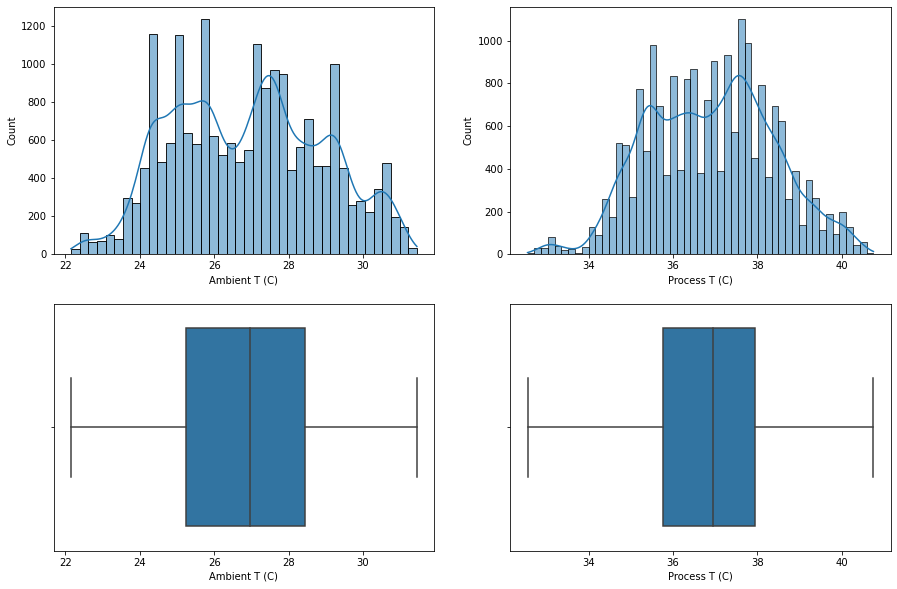

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.histplot(data=df, x='Ambient T (C)', kde=True, ax=ax[0,0])
sns.histplot(data=df, x='Process T (C)', kde=True, ax=ax[0,1])
sns.boxplot(data=df, x='Ambient T (C)', ax=ax[1,0])
sns.boxplot(data=df, x='Process T (C)', ax=ax[1,1])
plt.show()

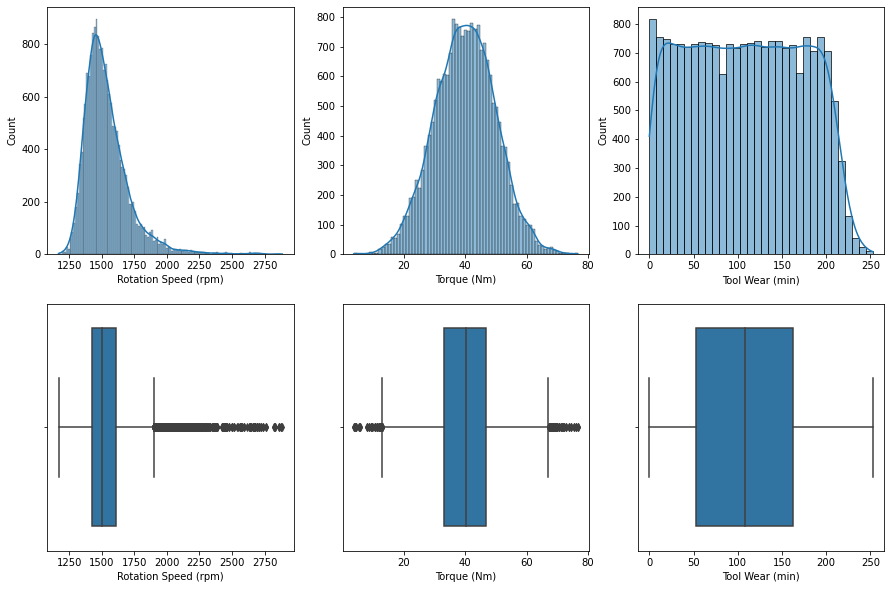

In [71]:
fig1, ax1 = plt.subplots(2, 3, figsize=(15,10))
sns.histplot(data=df, x='Rotation Speed (rpm)', kde=True, ax=ax1[0,0])
sns.histplot(data=df, x='Torque (Nm)', kde=True, ax=ax1[0,1])
sns.histplot(data=df, x='Tool Wear (min)', kde=True, ax=ax1[0,2])
sns.boxplot(data=df, x='Rotation Speed (rpm)', ax=ax1[1,0])
sns.boxplot(data=df, x='Torque (Nm)', ax=ax1[1,1])
sns.boxplot(data=df, x='Tool Wear (min)', ax=ax1[1,2])
plt.show()

- Most machines are in working condition 
- Based on Tool Wear(min) there are some machines that are in new condition 
- Rotation Speed(rpm) seems to have a positive skew
- Rotation Speed(rpm) seems to have a very high max value at 2886 with standard deviation of 178.This suggest that there's presence of extreme outliers in the data in the upper quartiles
- Torque(Nm) also contains outliers in both tails .
- ambient Temperature , Process Temperature and Torque seems to be Normally distributed 
- Tool Wear has a uniform distribution 



# Target Variable 

In [72]:
df.groupby(['Machine Status']).count()['Tool Wear (min)']

Machine Status
0    19322
1      678
Name: Tool Wear (min), dtype: int64

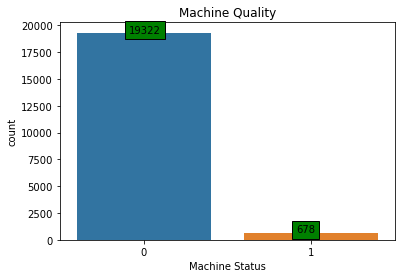

In [73]:
h = sns.countplot(x="Machine Status", data=df)
for i, u in enumerate(df['Machine Status'].value_counts().values):
    h.text(i-0.09, u, str(u), bbox=dict(facecolor='green', alpha=1))
plt.title('Machine Quality')
plt.show()

target variable is very imbalanced
19322 machines that didnt fail 
678 machines that failed 

3.5% of total machines failed 

might need to do more preprocessing as imbalance data could affect model's ability to generalise and predict

## Quantitative features 

In [75]:
numerical_features = ["Ambient T (C)","Process T (C)","Rotation Speed (rpm)","Torque (Nm)","Tool Wear (min)"]

In [74]:
df

,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,M,24.95,35.45,1551.0,42.8,0,0
1,L,25.05,35.55,1408.0,46.3,3,0
2,L,24.95,35.35,1498.0,49.4,5,0
3,L,25.05,35.45,1433.0,39.5,7,0
4,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...
19995,M,25.75,35.35,NaN,29.5,14,0
19996,H,25.85,35.35,1632.0,31.8,17,0
19997,M,25.95,NaN,NaN,33.4,22,0
19998,H,25.95,35.65,1408.0,48.5,25,0


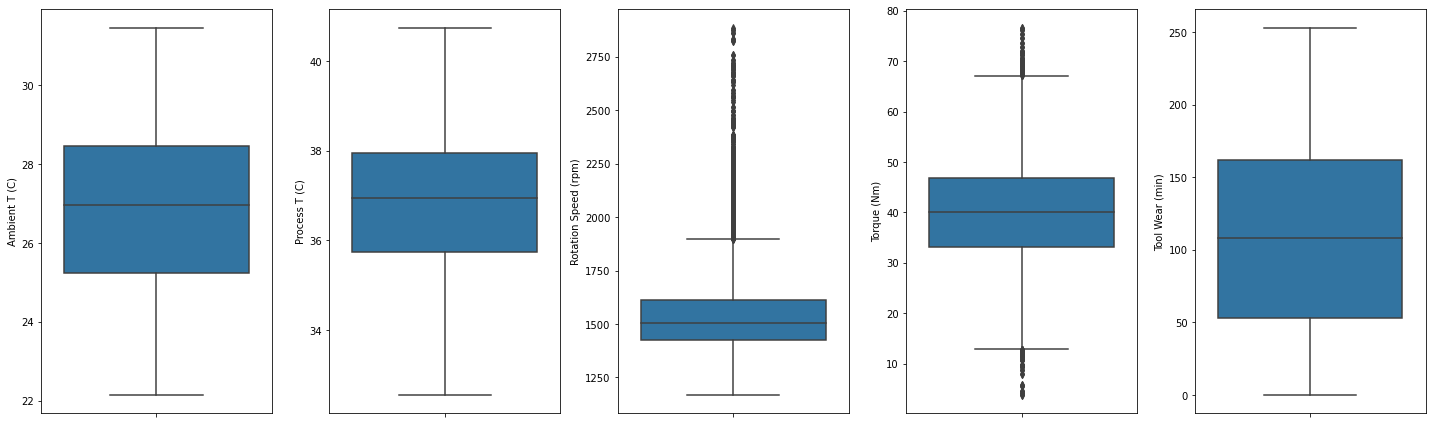

In [76]:
fig, ax = plt.subplots(1, len(numerical_features), figsize=(20, 6), tight_layout = True)

for idx, col in enumerate(numerical_features):
    ax[idx].ticklabel_format(useOffset=False, style='plain') # do not use scientific notation
    sns.boxplot(data = df, y=col, ax = ax[idx])

### From the boxplot 
- ambient temperature and process temperature have a very similiar distirbution with process temperature having a slightly higher median
- Rotation speed appears to have any outliers in it's right tail and it is positively skewed
- Torque is normallly distributed at median 40 Nm but has many outliers on both tails 

## Analysing discrete data
### distribution on Machine Quality and it's effect on target variable failure

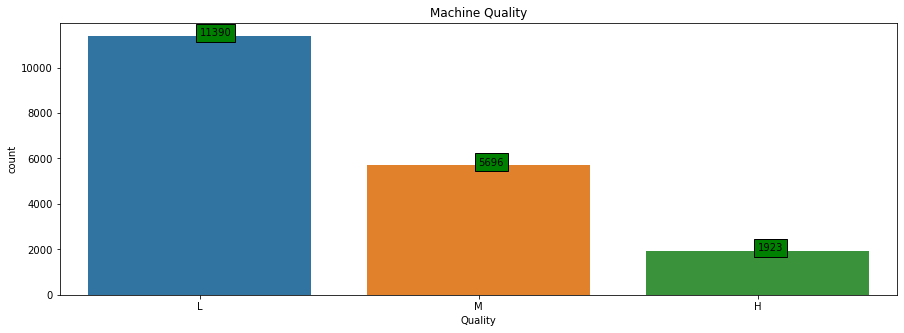

In [77]:
plt.figure(figsize=(15,5))
h=sns.countplot(x='Quality', data=df, order=['L','M','H'])
for i, u in enumerate(df['Quality'].value_counts().values):
    h.text(i, u, str(u), bbox=dict(facecolor='green', alpha=1))
plt.title('Machine Quality')
plt.show()

Text(0.5, 1.0, 'Correlation between Machine Status and Quality')

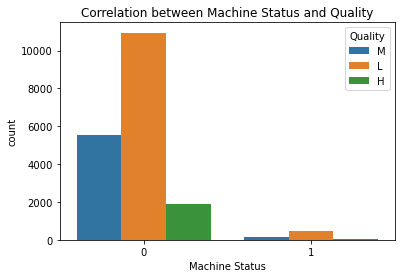

In [78]:
ax = sns.countplot(x="Machine Status", hue="Quality", data=df)
plt.title("Correlation between Machine Status and Quality")

## Based on the countplots above , I can conclude
- most machines are low quality
- there is very high number of low quality machines , then medium quality and high quality 
- logically a lower quality machine would produce a much higher failure rate , but based on the comparison bar plot , visually there's no correlation

## Investigating Outliers & Anomalies
During our EDA, we noted that many features had outlier data, which must be investigated. The reason is that we need to perform data cleaning to ensure that our model is able to have an accurate prediction and having too many outliers may severly impact our model's ability to learn and our ability to evaluate the model. 

Given that our distributions are heavily skewed, we will first apply a log transformation to deskew our data, before using Tukey's Fences to detect outliers.

In [618]:
def outlierDetection(df, var):
    col = df[var]
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (col > UpperFence) | (col < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("No. of Outliers:", len(outlier_df))
    sns.boxplot(y = var,data = df)
    plt.title(f"Box Plot of {var}")
    plt.show()
    return outlier_df

No. of Outliers: 722


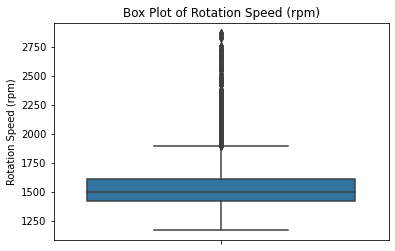

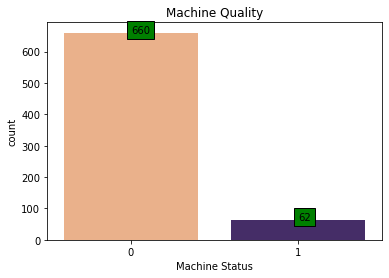

In [623]:
rotation_outlier = outlierDetection(df, "Rotation Speed (rpm)")
h = sns.countplot(x="Machine Status", data=rotation_outlier,palette=["#FAAE7B",'#432371'])
for i, u in enumerate(rotation_outlier['Machine Status'].value_counts().values):
    h.text(i, u, str(u), bbox=dict(facecolor='green', alpha=1))
plt.title('Machine Quality')
plt.show()

In [81]:
rotation_outlier.describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,771.000000,757.000000,771.000000,771.000000,771.000000,771.000000
mean,27.163230,37.031242,2103.333333,18.846174,107.712062,0.084306
std,2.062808,1.507887,216.956317,3.588364,65.390417,0.278027
min,22.450000,32.850000,1899.000000,3.800000,0.000000,0.000000
25%,25.350000,35.950000,1950.500000,16.800000,45.000000,0.000000
50%,27.450000,37.250000,2016.000000,19.700000,110.000000,0.000000
75%,28.750000,38.050000,2182.000000,21.500000,165.000000,0.000000
max,31.250000,40.650000,2886.000000,25.000000,244.000000,1.000000


### Outlier For Rotation Speed 
- No. of Outliers: 771
- 65 of the outliers are machine failures around 10% of outliers are machine failure 
- around 10% of total outliers 
- ambient temperature,process temperature,Tool Wear are not affected by rotation speed outliers
- mean of torque is alot lower at 18.8Nm compared to general which is 40Nm.


No. of Outliers: 104


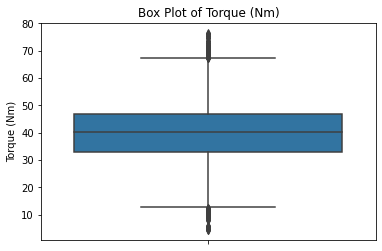

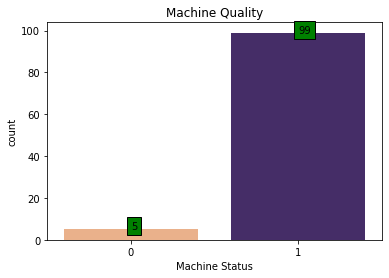

In [629]:
torque_outlier = outlierDetection(df, "Torque (Nm)")
h = sns.countplot(x="Machine Status", data=torque_outlier,palette=["#FAAE7B",'#432371'],order = df.groupby('Machine Status').size().sort_values().index[::-1])
for i, u in enumerate(torque_outlier['Machine Status'].value_counts().values[::-1]):
    h.text(i, u, str(u), bbox=dict(facecolor='green', alpha=1))
plt.title('Machine Quality')
plt.show()

In [83]:
torque_outlier .describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,138.000000,133.000000,131.000000,138.000000,138.000000,138.000000
mean,27.242029,37.043233,1855.900763,45.620290,98.202899,0.898551
std,2.209074,1.634440,695.805221,29.513395,63.169932,0.303023
min,22.650000,33.150000,1192.000000,3.800000,0.000000,0.000000
25%,25.375000,35.650000,1274.000000,12.100000,49.000000,1.000000
50%,27.450000,37.150000,1331.000000,67.800000,94.000000,1.000000
75%,28.850000,38.150000,2661.000000,69.400000,143.000000,1.000000
max,31.250000,40.450000,2886.000000,76.600000,234.000000,1.000000


### Outliers for Torque(Nm)
- Number of outliers :138 
- out of which 124 is machines that failed out of 138 which is 90% of all the outliers 
- accounts for 18% of all the machines that failed
- When a machine is excerting too much power it might cause machine failure
- Torque is a good indicator or whether a machine is going to fail
- torque outliers have slighly higher Tool Wear(min) than average
- slightly higher rotation speed than average
- ambient temperature and process temperature is not affected


### Bivariate Analysis
We now want to move on and investigate the relationships between the variables in our data.

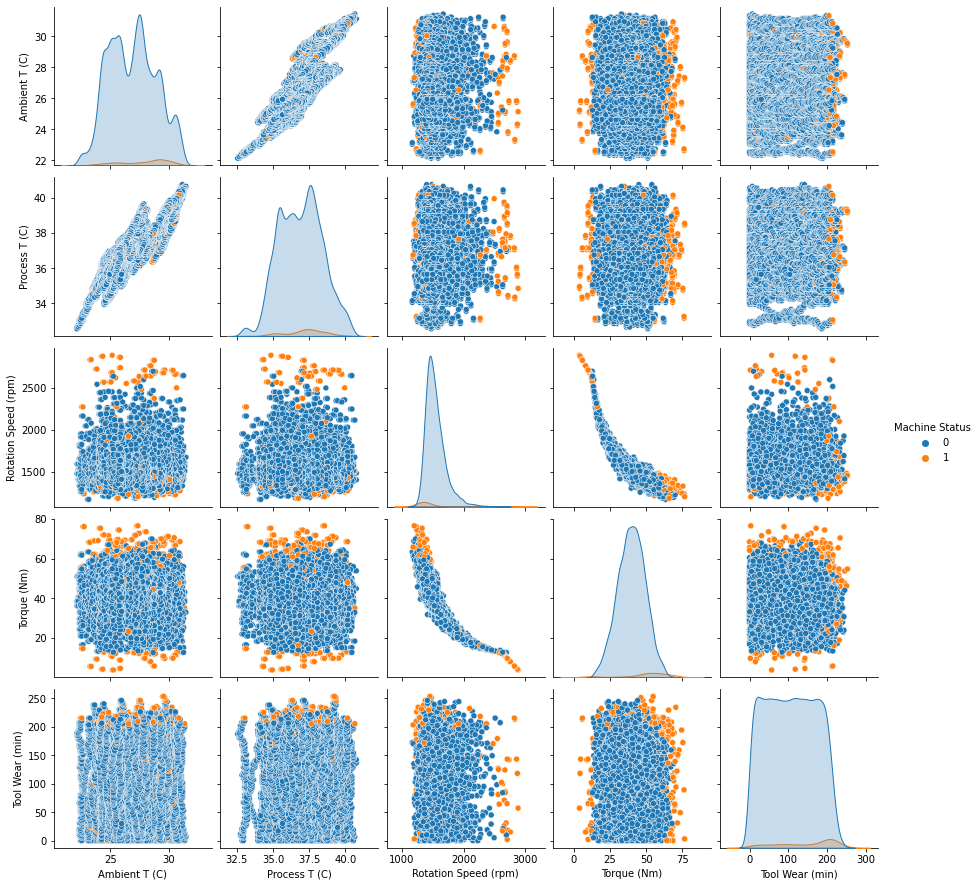

In [66]:
sns.pairplot(df,hue = "Machine Status")

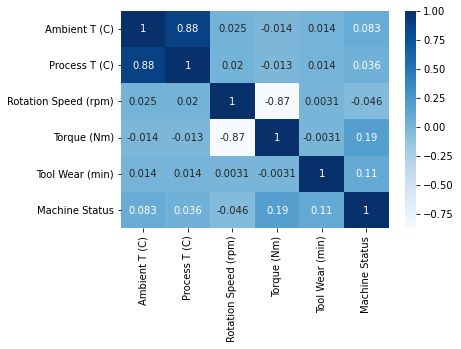

In [84]:
sns.heatmap(df.corr(), cmap="Blues", annot=True);

From the correlation plot , we note that 
- tool wear is the most correlated to machine status 
- process Temperature seem to be correlated to Ambient temperature 
    - this make sense before if the ambient temperature is high it would cause the machine to have higher internal temperature
- rotation seed and torque is negatively correlated to torque 
    - reason for this is because these two variable are related by Power.
    
    $$Power (W) = \frac{Torque (Nm)*Rotation Speed (rpm)}{5252}$$
    
- the other variables are not correlated or have a very low correlation 
    
Hences these strong correlation are not strong enough to justify removal of any features. However I will be doing feature creation to make better use the variables

# Feature Creation

### Factors that can cause a machine to fail

1. tool wear failure
    - machines will fail if it has been working for long periods of time 

2. heat dissipation failure
   - will occur is machine is exposed at high temperature at extended period of time 
   
   - given by $$ Heat dissipation[rpminC] = (Ambient T(C) - Process T (C))*Rotation Speed (rpm)$$

3. power failure
    - physics formula , machines might fail if it is consuming alot of power
    
    $$Power (W) = \frac{Torque (Nm)*Rotation Speed (rpm)}{5252}$$
    
    - Since the power(w) is going to get normalised i will exclude /5252
    
    $$Torque (Nm)*Rotation Speed (rpm)$$

4. overstrain failure
    
    - Machine will fail if it is running for long periods of time at high power
    
    $$Torque (Nm)*Tool Wear (min)$$
    

5. random error

    - Errors in the machines will occur randomly and it is unpredictable

In [593]:
df['Power [W]'] = df['Torque (Nm)']*df['Rotation Speed (rpm)']
df['Overstrain [minNm]'] = df['Torque (Nm)'] * df['Tool Wear (min)']
df['Heat dissipation [rpminC]'] = abs(df['Ambient T (C)'] -df['Process T (C)'])*df['Rotation Speed (rpm)']

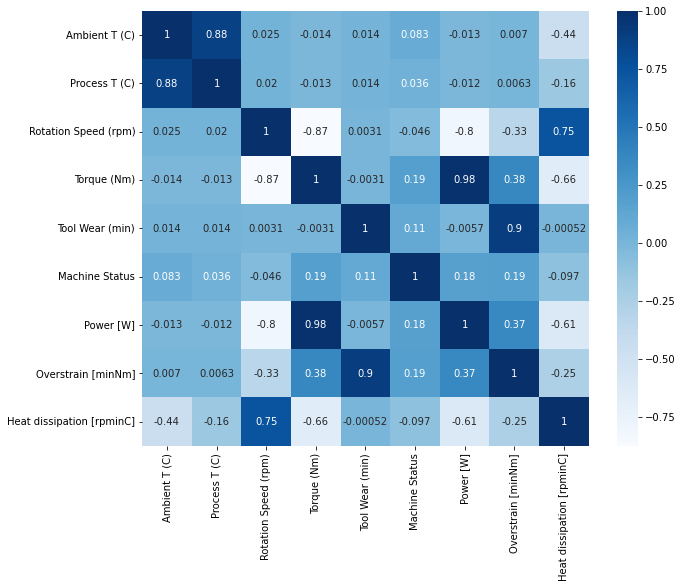

In [86]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="Blues", annot=True);

interval columns not set, guessing: ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status', 'Power [W]', 'Overstrain [minNm]', 'Heat dissipation [rpminC]']


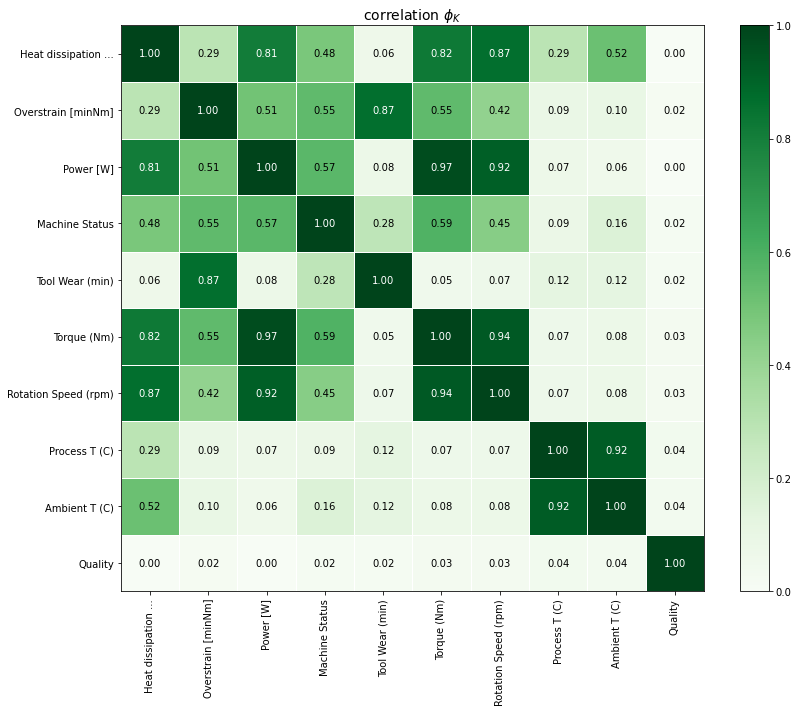

In [87]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12,10))
plt.tight_layout()

# Based on the phik correlation 

All the features that i created has a moderate correlation to the target variable 
Pearson correlation is mostly testing for linear relationship and is seen to have a lower relationship compared to phik correlation. 

This is because phik correlation accounts for non linear relationship 

Heat dissicipation which is made up of ambient temperature - process temperature is a much better indicator compared to those 2 variables on it's own . 

In [594]:

X, y = df.drop(['Machine Status'],axis = 1),df['Machine Status']


# split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20)


In [515]:
from sklearn.feature_selection import chi2, RFECV,RFE
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve, plot_roc_curve,precision_score,recall_score,roc_auc_score
from imblearn.combine import SMOTEENN
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Feature selection
Feature selection is necessary as there's many features that is highly correlated and could affected the performance of the model 

i have also created a few features . and it's good to see their importance and how useful are they 

In [361]:
from imblearn.pipeline import Pipeline

cat_features = ['Quality']
num_features = ["Ambient T (C)","Process T (C)","Torque (Nm)","Tool Wear (min)","Power [W]","Overstrain [minNm]"]
skewed_features = ['Rotation Speed (rpm)','Heat dissipation [rpminC]']

num_features_pipe = Pipeline([
    ("scaler",StandardScaler())
])

cat_features_pipe = Pipeline([
    ("Ordinal_encoding",OrdinalEncoder())]
)

skwed_features_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("fixing the skew",PowerTransformer(method='yeo-johnson', standardize=False))]
)

prep_pipe = ColumnTransformer([
    ("cat", cat_features_pipe, cat_features),
    ("num", num_features_pipe, num_features),
    ("skew",skwed_features_pipe,skewed_features)
],remainder = "drop")

# Check for futher multilinear colineararity
using VIF is used to check for colineararity a value of 5 means that the result is highly correlated but high correlation does not have an effect on the model's predictive performance 

The point of VIF in this case is just to find highly correlated features and possibily remove if it is redundant .

In [360]:

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(exog_df):
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [32]:
scaled = prep_pipe.fit_transform(X_train)
X_transformed = pd.DataFrame(scaled,index = X_train.index,columns = X_train.columns)
variance_inflation_factors(X_transformed)

C:\Users\yuwei\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


const                          5.055175
Quality                        1.001208
Ambient T (C)                 95.707648
Process T (C)                 53.893974
Rotation Speed (rpm)         790.220644
Torque (Nm)                   17.138490
Tool Wear (min)              389.577140
Power [W]                     19.933879
Overstrain [minNm]           157.846310
Heat dissipation [rpminC]     46.279184
Name: VIF, dtype: float64

# Feature importance 

In [33]:
scaled = prep_pipe.fit_transform(X_train)
X_transformed = pd.DataFrame(scaled,index = X_train.index,columns = X_train.columns)
X_resample,y_resample = SMOTEENN().fit_resample(X_transformed, y_train)
selector = RFE(GradientBoostingClassifier(), n_features_to_select=1, step=1)
selector = selector.fit(X_resample,y_resample)
selected_rfe_features = pd.DataFrame({"features":list(X_train.columns),"ranking":selector.ranking_})
selected_rfe_features

,features,ranking
0,Quality,8
1,Ambient T (C),7
2,Process T (C),9
3,Rotation Speed (rpm),2
4,Torque (Nm),3
5,Tool Wear (min),4
6,Power [W],6
7,Overstrain [minNm],1
8,Heat dissipation [rpminC],5


# Features that i end up dropping
1. process temperature and ambient temperature is not useful by it's self as it provide no context 
    the feature that i created "heat dissipation" is better at capturing the difference 
    
2. it can be seen that the is some log scaliing to be added into the pipeline as there are some values that is skewed
    heat dissipation and rotation speed
    
  


## Recreation of column transformer to include power transformation + dropping columns thats not used

# Pipeline
We decided to make use of pipeline to wrap several preprocessing modules to preprocess the data before parsing it into the final model.

Pipeline Members:
1. ColumnTransformer : Split between different pipeline for categorical features(to be ordinally encoded) and numerical features(to be normalised).
2. Ordinal Encoder , convert Categorical variable into numberical numbers based on it's hierarchy.
3. RobustScaler : Ensures features with outliers features are scaled and not affected by outliers as it is scaled according to the quantile range
4. Standard scaler :  Ensures features are at the same scale of mean = 0, standard deviation = 1
5. Fixing the skew using yeo-johnson power transformer to deskew data.
6. the remainder of the columns that is not transformed to be dropped

# New pipeline for features that is selected

In [595]:
from imblearn.pipeline import Pipeline

cat_features = ['Quality']
num_features = ["Torque (Nm)","Tool Wear (min)","Power [W]","Overstrain [minNm]"]
skewed_features = ['Rotation Speed (rpm)','Heat dissipation [rpminC]']

num_features_pipe = Pipeline([
    ("scaler",StandardScaler())
])

cat_features_pipe = Pipeline([
    ("Ordinal_encoding",OrdinalEncoder())]
)

skwed_features_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("fixing the skew",PowerTransformer(method='yeo-johnson', standardize=False))]
)

prep_pipe = ColumnTransformer([
    ("cat", cat_features_pipe, cat_features),
    ("num", num_features_pipe, num_features),
    ("skew",skwed_features_pipe,skewed_features)
],remainder = "drop")


## Generate Utility function to check the general performance of all the models

# Pipeline

In the pipeline it includes 3 different steps.

step 1 which is the preprocessing . Our dataset contains 2 types of variables , categorical and numerical . 
For the categorical variable Quality , i have decided to use Ordinal Encoder as there is an intrinsic order order that goes High quality , Medium quality and then Low Quality . 
Since the machine is to identify which machines is going to fail Low quality is going to take the value of 3 , medium = 2 and high = 1.

Some features are also seen to have outliers such as Rotation speed and Heat dissipation . 
I will run a two step process , step 1 will be robust scaler which is not prone to outliers and Power Transformer using the yeo-johnson method . This is to deskwed the data as most models assumes the data to be in a normal distribution.

The second part of the pipeline is SMOTEENN which stands for Synthetic Minority Oversampling Technique EDited Nearest Neighbours. THis is an oversampling technique used to to improve the model's sensitivity to the miniority class when there's an imbalance in data. This is found in a open sourced library named imbalance learn that generates synethic data for the miniority based on existing data. 



In [616]:
clf = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',GradientBoostingClassifier())
            ])


In [617]:
from imblearn.combine import SMOTEENN 
# Defining Utility Function 
def evaluate_model(models, X_train, y_train):
    hist = {}
    n_models = len(models)
    
    for idx, model in tqdm(enumerate(models)):
        clf = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',model())
            ])
#         except:
#             clf = model()
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        acc_train = accuracy_score(y_train, yhat_train)
        f1_train = f1_score(y_train, yhat_train)
        auc_train = roc_auc_score(y_train, yhat_train)
        recall_train = recall_score(y_train, yhat_train)
        
        # 5-Fold CV
        cv_hist = cross_validate(clf, X_train, y_train, scoring=['accuracy', 'f1', 'roc_auc','recall'], n_jobs=-1)
        # Record down the performance
        hist[model.__name__] = dict(
            train_acc = acc_train,
            cv_acc = cv_hist['test_accuracy'].mean(),
            train_f1_score = f1_train,
            cv_f1_score = cv_hist['test_f1'].mean(),
            train_auc = auc_train,
            cv_auc = cv_hist['test_roc_auc'].mean(),
            train_recall = recall_train,
            cv_recall_score = cv_hist['test_recall'].mean(),
            recall_gap = recall_train - cv_hist['test_recall'].mean()
        )

    display(pd.DataFrame(hist).T)

In [600]:
# Classification Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

models = [
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    KNeighborsClassifier,
    GradientBoostingClassifier,
    Perceptron,
    ExtraTreesClassifier,
    GaussianNB,
    MLPClassifier,
    RidgeClassifier,
    RidgeClassifierCV,
    CalibratedClassifierCV,
    SGDClassifier
]
evaluate_model(models, X_train, y_train)

14it [01:57,  8.41s/it]


,train_acc,cv_acc,train_f1_score,cv_f1_score,train_auc,cv_auc,train_recall,cv_recall_score,recall_gap
LogisticRegression,0.826071,0.823789,0.237097,0.233798,0.822451,0.906682,0.818575,0.814212,0.004362
DecisionTreeClassifier,0.989660,0.976824,0.864359,0.723799,0.993610,0.949409,0.997840,0.920056,0.077784
RandomForestClassifier,0.990444,0.980104,0.873346,0.754606,0.994016,0.989586,0.997840,0.924381,0.073460
AdaBoostClassifier,0.948656,0.945946,0.550562,0.528019,0.950504,0.979183,0.952484,0.907059,0.045424
KNeighborsClassifier,0.969621,0.954717,0.684911,0.559305,0.984292,0.931792,1.000000,0.868256,0.131744
GradientBoostingClassifier,0.954860,0.949867,0.585462,0.550563,0.959971,0.982750,0.965443,0.926601,0.038842
Perceptron,0.919347,0.803043,0.320721,0.218520,0.753861,0.884142,0.576674,0.777256,-0.200582
ExtraTreesClassifier,0.987164,0.979463,0.836957,0.742152,0.992320,0.989535,0.997840,0.892006,0.105835
GaussianNB,0.838266,0.836482,0.264591,0.263114,0.859004,0.938751,0.881210,0.883403,-0.002194
MLPClassifier,0.949939,0.944876,0.561798,0.523609,0.960556,0.976882,0.971922,0.915732,0.056191


## BaseLine algorthm i will use logistic regression 

seems to have a decent perforamnce 0.814 of cv score . but has one of the lowest cv accuracy score at 0.823 .
Based on comparing train_recall score and cv_recall score , the model doesnt seem to be overfitting. 

This is a good benchmark of other models as a comparison 

based on comparing recall_gap which is a simple guideline to check for overfitting or underfitting

## Based on what I see 
### We will be mainly focusing on the recall score

Most of the models are actually being overfitted

Tree models usually have the highest recall score , so i will be testing more of the tree models

Some of the models i will evaulate is DecisiontTree, Randomforest classifier,AdaBoostclassifier,GradientBoosting and MlPclassifier

guesses on why tree models work very well 
- seperations on machine failures are easily identified by tree models


the other model's CV_recall_score seems to quite low



In [62]:
#tune tree hyper parameters
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, learning_curve ,HalvingGridSearchCV

# Hyper parameter tunnning

# Hyperparameter tunning for randomforest classifier

then i will evaluate the model using learning to see the if it is overfitting or udnerfitting


In [36]:
from imblearn.pipeline import Pipeline

cat_features = ['Quality']
num_features = ["Torque (Nm)","Tool Wear (min)","Power [W]","Overstrain [minNm]"]
skewed_features = ['Rotation Speed (rpm)','Heat dissipation [rpminC]']

num_features_pipe = Pipeline([
    ("scaler", RobustScaler())
])

cat_features_pipe = Pipeline([
    ("Ordinal_encoding",OrdinalEncoder())]
)

skwed_features_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("fixing the skew",PowerTransformer(method='yeo-johnson', standardize=False))]
)

prep_pipe = ColumnTransformer([
    ("cat", cat_features_pipe, cat_features),
    ("num", num_features_pipe, num_features),
    ("skew",skwed_features_pipe,skewed_features)
],remainder = "drop")


In [142]:
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


imba_pipeline = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTE(random_state=0,n_jobs=-1),),
                ('model',RandomForestClassifier())
            ])

#ccp_alpha  -> Cost Complexity Pruning- Alpha
# based on comparing train_recall vs cv_recall score there's a large variability

param_grid = {'model__max_depth':[i for i in range(5,30)],
              'model__n_estimators':np.arange(50,110,10),
              'model__criterion':['gini','entropy'],
              'model__min_samples_split':np.arange(2,10),
              'model__min_samples_leaf':np.arange(2,5),
              'model__max_features':["sqrt","log2",None]
              
             }
grid_search = HalvingGridSearchCV(estimator=imba_pipeline,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
108000 fits failed out of a total of 108000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yuwei\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\yuwei\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\

C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
7200 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2400 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", 

{'model__criterion': 'gini',
 'model__max_depth': 6,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 4,
 'model__n_estimators': 50}

## Code to plot learning curve

### used to check if model is overfitting and evaluate which is the best features

In [603]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42),
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring= "recall",
        cv=StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42),
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
\
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times

    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]

    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



### Firstly i will check the baseline algorithm
logistic regression learning curve without tunning

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

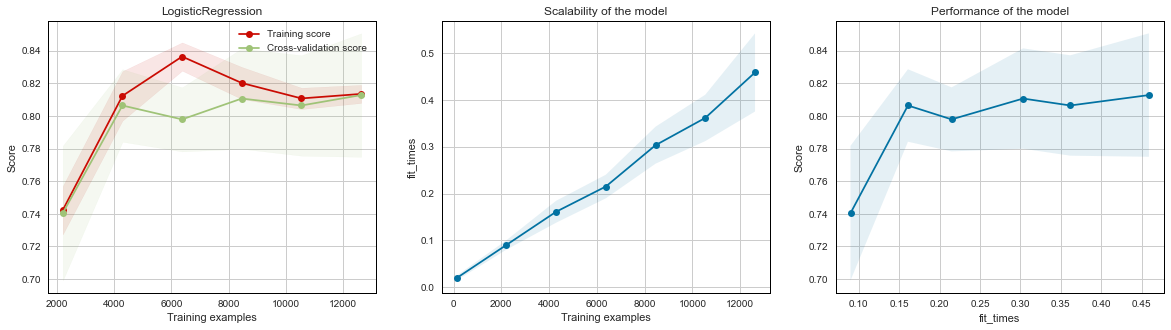

In [379]:
LogisticRegression_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',LogisticRegression())
            ]) 

plot_learning_curve(LogisticRegression_pipe,"LogisticRegression",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 7))

### Evaluation on learning curve

Model initial have a very low average crossvalidation score at 0.78 and have a  variance confidence interval from 0.70 to 0.78. as the model got more data perforamcen increased to 0.81 at 400 training examples and remained stagnant . This shows that data is overfitting the training model . It eventually converges at a recall score of 0.81 .

## Hyperparamter tunning + model evaluation for GradientBoosting

In [359]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

In [608]:
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


imba_pipeline = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0,n_jobs=-1)),
                ('model',GradientBoostingClassifier())
            ])

#ccp_alpha  -> Cost Complexity Pruning- Alpha
# based on comparing train_recall vs cv_recall score there's a large variability

param_grid = {
              'model__max_depth':np.arange(1,40,2),
              "model__n_estimators":np.arange(10,200,15),
              "model__max_features":["auto","sqrt","log2"],
              'model__criterion':['friedman_mse','squared_error'],
              "model__learning_rate":[0.01,0.1,1,10,100]
             }
grid_search = HalvingGridSearchCV(estimator=imba_pipeline,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'model__criterion': 'friedman_mse',
 'model__learning_rate': 0.01,
 'model__max_depth': 25,
 'model__max_features': 'auto',
 'model__n_estimators': 130}

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

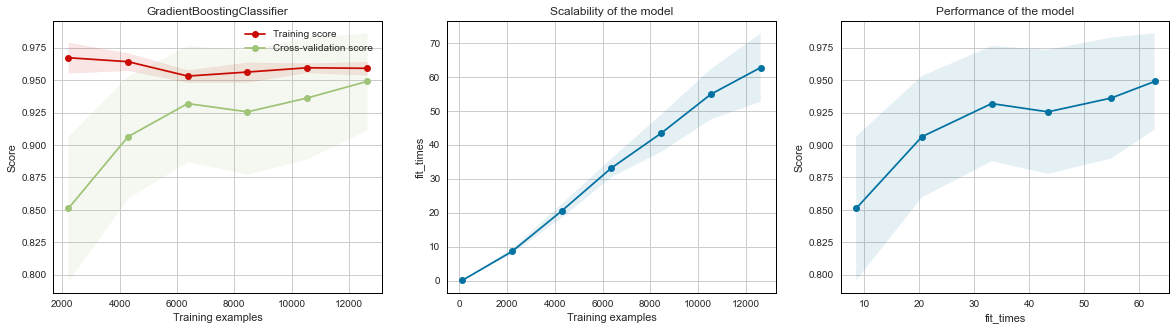

In [360]:

tree_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',GradientBoostingClassifier(
                    criterion = "friedman_mse",
                    max_depth = 25,
                    max_features = 'auto',
                    learning_rate = 0.1,
                    n_estimators = 130,
                    ccp_alpha = 0.001
                ))
            ])

plot_learning_curve(tree_pipe,"GradientBoostingClassifier",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 7))

### Learning curve interpretation 
learning curve shows high variability through out the cross-validation then at 800 training examples , it converges at an f1 score of around 0.95.We can see that the training and test scores have not yet converged, so potentially this model would benefit from more training data.This model mainly suffer from the high variance so it is possible that it is overfitting

In [63]:
def plot_learning_curve(model, X, y, scoring, cv = StratifiedKFold(shuffle=True, random_state = 42), train_sizes = np.linspace(.1, 1.0, 5)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=scoring)
  print("asdasdasdasdsa")
  scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  print(scores['Train Sizes'])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve of {model_name}")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel("Train Sizes")
  return fig

# Learning curve for random forest

In [123]:
f2_score = make_scorer(fbeta_score, beta = 2) # define our f2 score

metrics = {
    "f2" : f2_score,
    "accuracy" : "accuracy",
    "recall" : "recall" 
}
def evaluate_candidate_model(clf, X, y, metrics = metrics, cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is not None else type(clf).__name__
    scores = cross_validate(clf, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator, n_jobs= -1)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_f2"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    his_snapshot = scores.iloc[0, :]
    his_snapshot["Standard Error of F2 Score"] = scores["test_f2"].iloc[1] / np.sqrt(cv.get_n_splits())
    his_snapshot["Performance Gap"] = his_snapshot["train_f2"] - his_snapshot["test_f2"]
    his_snapshot.rename(index=model_name, inplace=True)
    history = history.append(his_snapshot)
    if return_learning_curve:
      lr = plot_learning_curve(clf, X, y, scoring='recall', cv = cv)
    return scores, history, lr if return_learning_curve else None, best_estimator if return_estimator else None

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

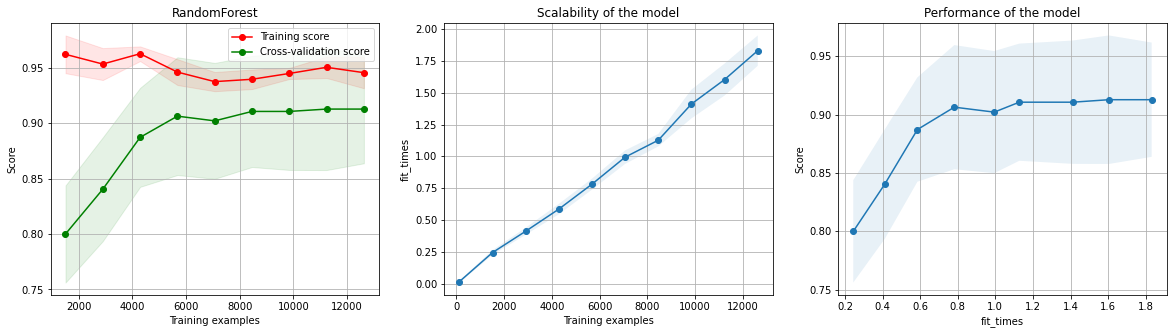

In [245]:
forest_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',RandomForestClassifier(max_depth=5,max_features = 'sqrt',n_estimators=50,criterion='gini'))
            ])
# {'model__criterion': 'gini',
#  'model__max_depth': 6,
#  'model__max_features': 'sqrt',
#  'model__min_samples_leaf': 4,
#  'model__min_samples_split': 4,
#  'model__n_estimators': 50}
plot_learning_curve(forest_pipe,"RandomForest",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 10))

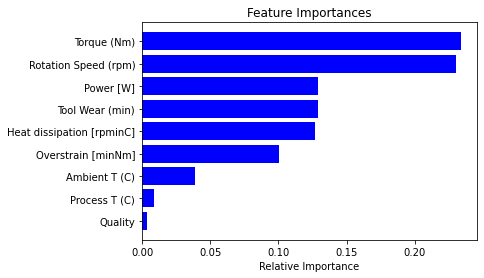

In [255]:
features = ['Quality','Ambient T (C)','Process T (C)','Rotation Speed (rpm)','Torque (Nm)','Tool Wear (min)','Power [W]','Overstrain [minNm]','Heat dissipation [rpminC]']
importances = forest_pipe[2].feature_importances_
indices = np.argsort(importances)[-9:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Based on the features importance of Random forest 
It is seen that Quality has a very low importance on the model

# MLPClassifier 
a neural network classifier 


In [197]:
imba_pipeline = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0,n_jobs=-1)),
                ('model',MLPClassifier())
            ])

#ccp_alpha  -> Cost Complexity Pruning- Alpha
# based on comparing train_recall vs cv_recall score there's a large variability

param_grid = {
    'model__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
             }
grid_search = HalvingGridSearchCV(estimator=imba_pipeline,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'model__activation': 'relu',
 'model__alpha': 0.05,
 'model__hidden_layer_sizes': (50, 100, 50),
 'model__learning_rate': 'constant',
 'model__solver': 'sgd'}

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

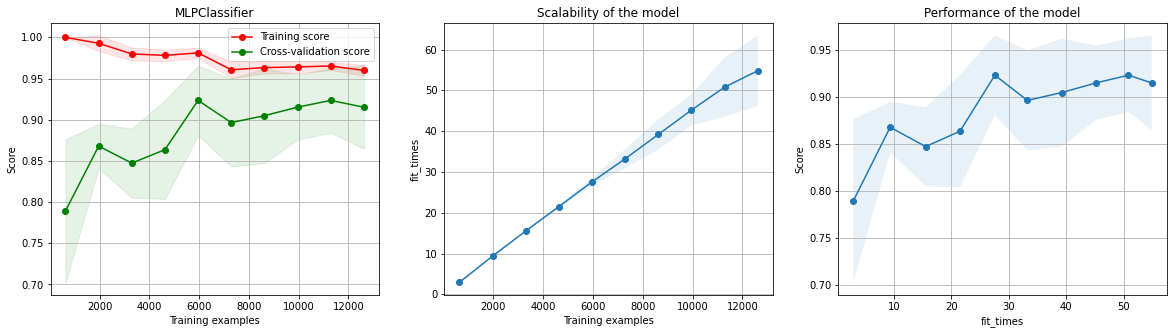

In [201]:
forest_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',MLPClassifier())
            ])
# {'model__criterion': 'gini',
#  'model__max_depth': 6,
#  'model__max_features': 'sqrt',
#  'model__min_samples_leaf': 4,
#  'model__min_samples_split': 4,
#  'model__n_estimators': 50}
plot_learning_curve(forest_pipe,"MLPClassifier",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.05, 1.0, 10))

In [609]:
imba_pipeline = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0,n_jobs=-1)),
                ('model',DecisionTreeClassifier())
            ])

#ccp_alpha  -> Cost Complexity Pruning- Alpha
# based on comparing train_recall vs cv_recall score there's a large variability

param_grid = {
        "model__criterion":["gini","entropy"],
        "model__max_depth":np.arange(5,25),
        "model__min_samples_split":np.arange(2,5),
        "model__min_samples_leaf":np.arange(2,5),
        "model__max_features":['auto',"sqrt","log2"]
             }
grid_search = HalvingGridSearchCV(estimator=imba_pipeline,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 2}

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

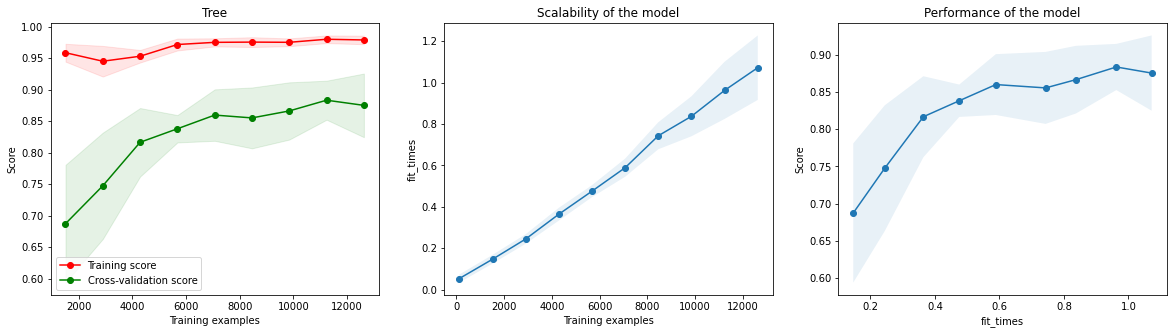

In [610]:
forest_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',DecisionTreeClassifier(criterion= "gini",max_depth = 20,max_features= 'auto',min_samples_leaf = 4,min_samples_split = 2))
            ])
# {'model__criterion': 'gini',
#  'model__max_depth': 6,
#  'model__max_features': 'sqrt',
#  'model__min_samples_leaf': 4,
#  'model__min_samples_split': 4,
#  'model__n_estimators': 50}
plot_learning_curve(forest_pipe,"Tree",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 10))

In [246]:
forest_pipe.fit(X_train,y_train)
forest_pipe[2].feature_importances_

array([0.00342032, 0.03846487, 0.00832314, 0.23030085, 0.23403941,
       0.12869723, 0.12917545, 0.10067506, 0.12690367])

### As many features are also correlated to each other, there might be a problem of overfitting the data 
#### Lasso Regularization
#### Next i will tune the model for model selection

We will attempt to apply an L1 penalty on our Logistic Regression model to automatically select features through L1 Regularization.

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

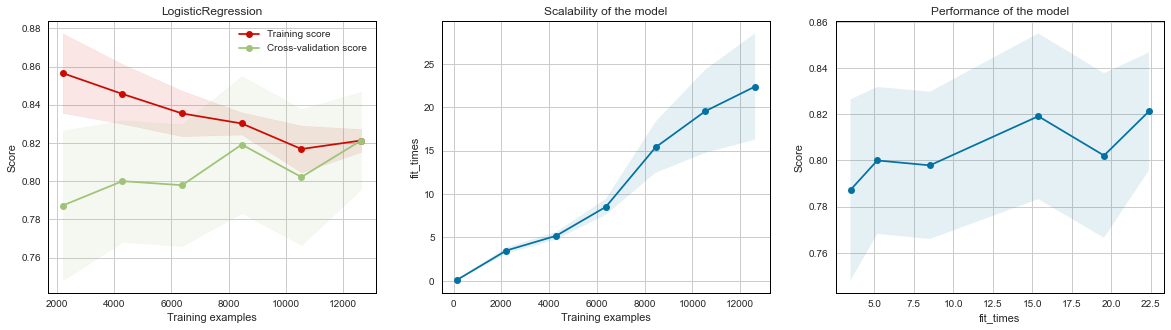

In [399]:
logreg_improve = Pipeline([
    ("preprocess", prep_pipe),
    ("oversample",SMOTEENN(random_state=0)),
    ('Model', LogisticRegression(penalty="l1",solver="liblinear"))
])

plot_learning_curve(logreg_improve,"LogisticRegression",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 7))

## But based on the learning curve
- it doesnt not look like the best choice 
- the recall score is only 0.82 
- the model did not gain any learn any information from the data from 2000 instance onwards.

### so instead i will do feature selection using randomforest classifier which has a higher recall score of 0.91 

## Testing if doing future feature selection can attain a better result

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

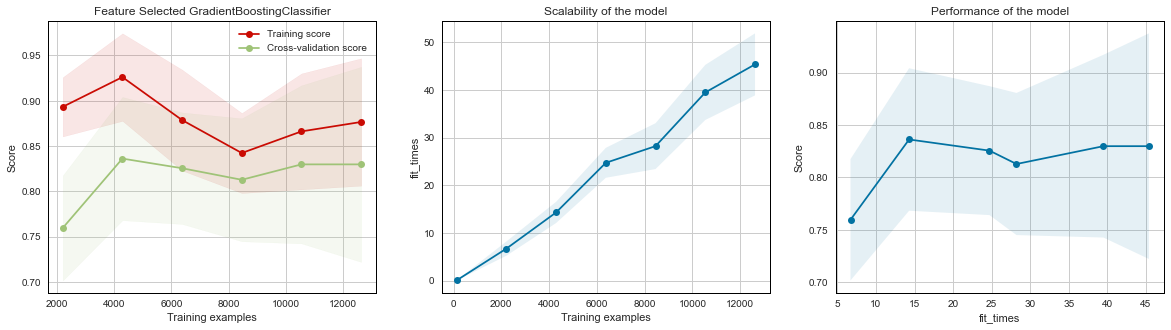

In [403]:
from sklearn.feature_selection import SelectFromModel
testing_feature_selection_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ("feature selection",SelectFromModel(RandomForestClassifier(max_depth=5,max_features = 'sqrt',n_estimators=50,criterion='gini'))),
                ('model',GradientBoostingClassifier(
                    criterion = "friedman_mse",
                    max_depth = 25,
                    max_features = 'auto',
                    learning_rate = 0.1,
                    n_estimators = 130,
                    ccp_alpha = 0.001
                ))
            ])
plot_learning_curve(testing_feature_selection_pipe,"Feature Selected GradientBoostingClassifier",X_train,y_train,n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 7))

### Based on the Learning curve removing more features seemed to have an significant adverse effect on the performance of the model
with recall cross-validation score dropping from 0.95 to only 0.83,
This is because all the features i have select is already the minimum and any more reduction will not benefit the model


# Stupid Baseline
i will be using the dummy classifier

In [613]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

Text(0.5, 0.98, 'Confusion Matrix')

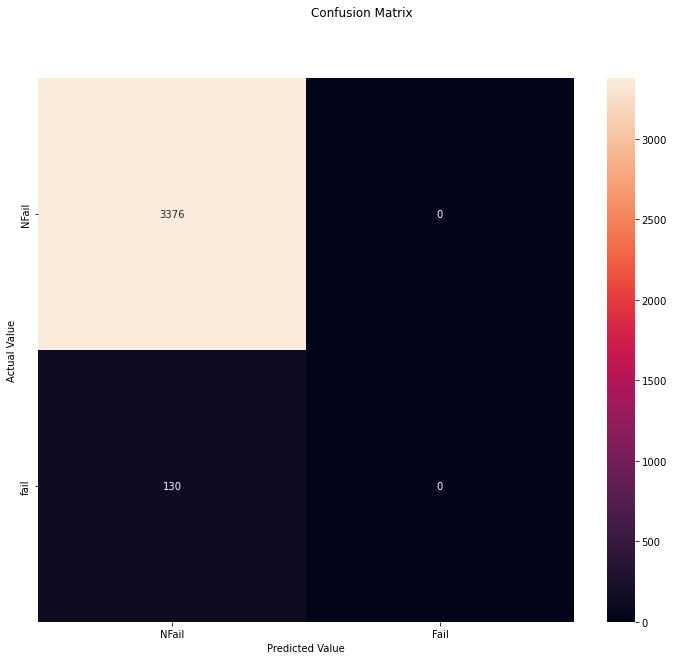

In [614]:

fig, ax = plt.subplots(figsize=(12, 10))
y_pred =dummy_clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=ax)
ax.set_ylabel("Actual Value")
ax.set_xlabel("Predicted Value")
ax.set_xticklabels(["NFail", "Fail"])
ax.set_yticklabels(["NFail", "fail"])
fig.suptitle("Confusion Matrix")

# ROC curve 

C:\Users\yuwei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


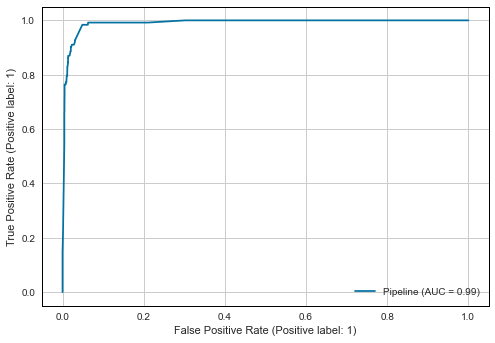

In [405]:
from sklearn.metrics import roc_curve
final_pipe = Pipeline([
                ("preprocess", prep_pipe),
                ("oversample",SMOTEENN(random_state=0)),
                ('model',GradientBoostingClassifier(
                    criterion = "friedman_mse",
                    max_depth = 25,
                    max_features = 'auto',
                    learning_rate = 0.1,
                    n_estimators = 130,
                    ccp_alpha = 0.001
                ))
            ])
final_pipe.fit(X_train,y_train)
plot_roc_curve(final_pipe, X = X_test, y = y_test)

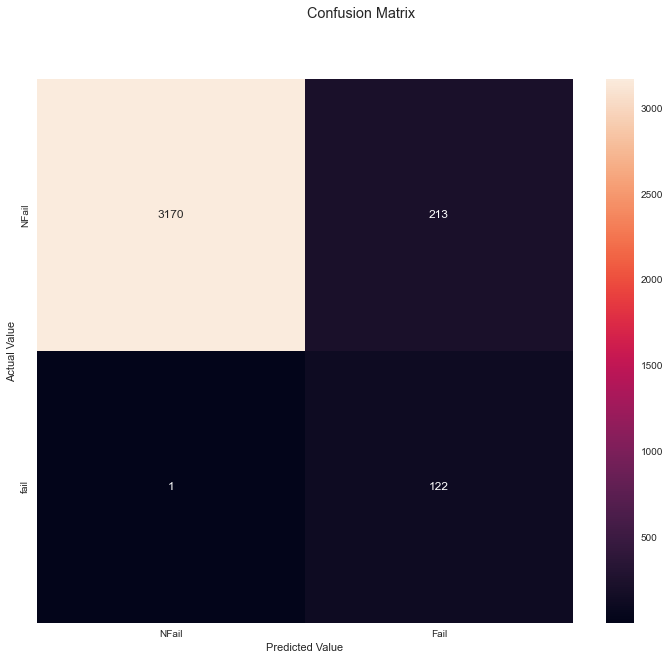

In [406]:

fig, ax = plt.subplots(figsize=(12, 10))
y_pred =final_pipe.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=ax)
ax.set_ylabel("Actual Value")
ax.set_xlabel("Predicted Value")
ax.set_xticklabels(["NFail", "Fail"])
ax.set_yticklabels(["NFail", "fail"])
fig.suptitle("Confusion Matrix")

## What have i learned
1. learn about what is the right way of oversampling or undersampling data 
2. learned more about data leakage and how oversampling before crossvalidation could cause dataleakage
3. Found out pandas-profiling could help improve eda and spot out things i couldnt in normal eda